<h2>Imports and constants</h2>

In [152]:
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pycountry
import numpy as np
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
%matplotlib inline

In [153]:
data_path = 'data/'
#data_path = 'C:\Users\Jakob\Desktop\RMIT\Practical Data Science\Assignment 2\\'

<h2>Merging world cities and cost of living index datasets</h2>

In [154]:
# Load world cities
new_cities = pd.read_csv(data_path + 'worldcitiespop.csv', sep=",")
# Take only first 2000 most populated cities and drop any duplicates in city names.
new_cities = new_cities.sort_values("Population", ascending=False)[0:2000].drop_duplicates("City")
new_cities["Country"] = new_cities["Country"].str.upper()
new_cities = new_cities[["City", "Country", "Population", "Latitude", "Longitude"]]

In [155]:
# Load cost of living index
coli = pd.read_csv(data_path + 'Cost_of_living_index.csv', sep=",")

In [156]:
# Parse original "City" column to "City" and "Country" columns
coli["City"], coli["Country"] = coli["City"].str.split(", ", 1).str
# Remove state from the USA Country.
coli["Country"] = coli["Country"].apply(lambda x: "United States" if "United States" in x else x)
coli["City"] = coli["City"].str.lower()
coli = coli[["City", "Country", "Cost of Living Plus Rent Index", "Local Purchasing Power Index"]]

In [157]:
# Transform country name to country code.
def name2code(country_name):
    rep = pycountry.countries.get(name=country_name)
    if rep is None:
        rep = pycountry.countries.get(official_name=country_name)
        if rep is None:
            return np.nan
        else:
            return rep.alpha_2
    else:
        return rep.alpha_2
coli["Country"] = coli["Country"].apply(lambda country_name: name2code(country_name))
coli.dropna(inplace=True)

In [158]:
# Check how many cities we have now.
new_cities.shape

(1969, 5)

In [159]:
# Merge new cities and cost of living index datasets.
df = pd.merge(new_cities, coli, on=["City", "Country"], how="inner")
df.shape

(359, 7)

In [160]:
# Are there still any duplicates?
df.City.value_counts().sort_values(ascending=False)[df.City.value_counts().sort_values(ascending=False) > 1]

portland    2
Name: City, dtype: int64

In [161]:
# Just Portland, remove it.
df = df[df["City"] != "portland"]

In [162]:
df.head(10)

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index
0,tokyo,JP,31480498.00,35.69,139.75,61.89,113.09
1,shanghai,CN,14608512.00,31.05,121.40,42.68,72.16
2,karachi,PK,11627378.00,24.91,67.08,15.50,36.66
3,delhi,IN,10928270.00,28.67,77.22,19.23,77.75
4,manila,PH,10443877.00,14.60,120.98,27.46,40.04
5,sao paulo,BR,10021437.00,-23.47,-46.67,31.11,41.16
6,istanbul,TR,9797536.00,41.02,28.96,25.24,50.13
7,lagos,NG,8789133.00,6.45,3.40,31.86,19.41
8,jakarta,ID,8540306.00,-6.17,106.83,29.39,28.95
9,new york,US,8107916.00,40.71,-74.01,100.00,100.00


In [163]:
df.shape

(357, 7)

<h2>Temperature</h2>

In [164]:
temperature = pd.read_csv(data_path + 'temperatures.csv', sep=',', decimal='.')

In [165]:
# Extract DateTime.
temperature['dt'] = pd.to_datetime(temperature['dt'])

In [166]:
temperature.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object

In [167]:
# Take average temperature for year 2012 (newest).
temperature['year'] = temperature.dt.dt.year
new_temperatures = temperature[temperature.year == 2012][['City', "Country", 'AverageTemperature']].groupby(['City', "Country"], as_index=False).mean()
new_temperatures["City"] = new_temperatures["City"].str.lower()

In [168]:
# Transform Country to code.
new_temperatures["Country"] = new_temperatures["Country"].apply(lambda country_name: name2code(country_name))
new_temperatures.dropna(inplace=True)

In [169]:
# Print cities throwed away due to lack of temperature information.
tmp = pd.merge(df, new_temperatures, on="City", how='left')
tmp[tmp["AverageTemperature"].isna()]

,City,Country_x,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Country_y,AverageTemperature
5,sao paulo,BR,10021437.00,-23.47,-46.67,31.11,41.16,NaN,nan
14,bogota,CO,7102602.00,4.65,-74.06,24.44,37.44,NaN,nan
57,brasilia,BR,2207812.00,-15.78,-47.92,29.76,63.24,NaN,nan
63,medellin,CO,2000001.00,6.25,-75.56,23.09,34.02,NaN,nan
157,merida,MX,717196.00,20.97,-89.62,18.19,40.29,NaN,nan
173,queretaro,MX,611803.00,20.60,-100.38,20.72,57.83,NaN,nan
187,dusseldorf,DE,577139.00,51.22,6.77,53.99,115.58,NaN,nan
193,malaga,ES,557875.00,36.73,-4.43,36.24,87.90,NaN,nan
199,cancun,MX,542156.00,21.17,-86.83,21.39,53.68,NaN,nan
209,asuncion,PY,508797.00,-25.27,-57.67,22.62,37.30,NaN,nan


In [170]:
# Merge temperature.
df = pd.merge(df, new_temperatures, on=["City", "Country"], how='inner')

In [171]:
# No duplicates among cities.
df["City"].value_counts(ascending=False).head()

plovdiv           1
tampere           1
brussels          1
lyon              1
port elizabeth    1
Name: City, dtype: int64

In [172]:
df.shape

(338, 8)

<h2>Liveability</h2>

In [173]:
liveability = pd.read_csv(data_path + 'liveability.csv', sep=',')

In [174]:
# Basic processing.
liveability["City"] = liveability.City.str.lower()
liveability = liveability[["City", "Movehub Rating"]]
liveability.rename(columns={"Movehub Rating": "Liveability"}, inplace=True)

In [175]:
liveability.head()

,City,Liveability
0,caracas,65.18
1,johannesburg,84.08
2,fortaleza,80.17
3,saint louis,85.25
4,mexico city,75.07


In [176]:
# Merge livability.
df = pd.merge(df, liveability, on="City", how='inner')

In [177]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability
0,tokyo,JP,31480498.00,35.69,139.75,61.89,113.09,13.11,80.00
1,shanghai,CN,14608512.00,31.05,121.40,42.68,72.16,16.47,75.69
2,karachi,PK,11627378.00,24.91,67.08,15.50,36.66,26.75,67.81
3,delhi,IN,10928270.00,28.67,77.22,19.23,77.75,25.89,77.12
4,manila,PH,10443877.00,14.60,120.98,27.46,40.04,27.34,68.31


In [178]:
df.shape

(160, 9)

<h2>Unemployment rate</h2>

In [179]:
unemployment = pd.read_csv(data_path + 'unemployment.csv', sep=',', decimal='.')

In [180]:
# Among all the indicators, we choose 3296 - Unemployment rate (% of total labor force) (WEO)
unemployment[["Indicator Id", "Indicator"]].drop_duplicates()

,Indicator Id,Indicator
0,346,Gross national savings (% of GDP)
1,347,"Inflation, average consumer prices"
2,352,Population (WEO)
3,354,General government total expenditure
4,355,General government net lending/borrowing
5,357,General government primary net lending/borrowing
6,359,General government gross debt
7,360,Gross domestic product corresponding to fiscal...
8,2777,General government total expenditure
9,2779,General government net lending/borrowing


In [181]:
# We are interested only in 3296 Indicator ID. We use current year 2019.
# We also drop observations with missing value.
unemployment = unemployment[unemployment["Indicator Id"] == 3296][["Country Name", "2019"]].dropna()
unemployment.rename(columns={"Country Name": "Country", "2019": "Unemployment rate"}, inplace=True)
unemployment["Country"] = unemployment["Country"].apply(lambda x: name2code(x))
unemployment.dropna(inplace=True)

In [182]:
# Merge unemployment rate.
df = pd.merge(df, unemployment, on="Country", how="inner")

In [183]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability,Unemployment rate
0,tokyo,JP,31480498.00,35.69,139.75,61.89,113.09,13.11,80.00,2.87
1,shanghai,CN,14608512.00,31.05,121.40,42.68,72.16,16.47,75.69,4.00
2,karachi,PK,11627378.00,24.91,67.08,15.50,36.66,26.75,67.81,6.14
3,lahore,PK,6312576.00,31.55,74.34,16.10,39.75,24.87,67.32,6.14
4,manila,PH,10443877.00,14.60,120.98,27.46,40.04,27.34,68.31,5.50


In [184]:
df.shape

(144, 10)

<h2>Freedom</h2>

In [185]:
freedom = pd.read_csv(data_path + 'Happiness.csv', sep =',', decimal='.')

In [186]:
# Transform country names to country codes, drop duplicates.
freedom = freedom[['Country', 'Freedom']]
freedom['Country'] = freedom['Country'].apply(lambda x: name2code(x))
freedom.dropna(inplace=True)

In [187]:
# Merge freedom.
df = pd.merge(df, freedom, on='Country', how='inner')

In [188]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability,Unemployment rate,Freedom
0,tokyo,JP,31480498.00,35.69,139.75,61.89,113.09,13.11,80.00,2.87,0.51
1,shanghai,CN,14608512.00,31.05,121.40,42.68,72.16,16.47,75.69,4.00,0.47
2,karachi,PK,11627378.00,24.91,67.08,15.50,36.66,26.75,67.81,6.14,0.24
3,lahore,PK,6312576.00,31.55,74.34,16.10,39.75,24.87,67.32,6.14,0.24
4,manila,PH,10443877.00,14.60,120.98,27.46,40.04,27.34,68.31,5.50,0.59


In [189]:
df.shape

(144, 11)

<h2>Wages</h2>

In [190]:
wages = pd.read_csv(data_path + 'average_wages.csv', sep=',', decimal='.')

In [191]:
# We take data from 2016 (newest)
wages = wages[wages['TIME'] == 2016].groupby('LOCATION', as_index=False).mean()

In [192]:
# Transform country code to actual country name.
wages["Country"] = wages["LOCATION"].apply(lambda country_code: pycountry.countries.get(alpha_3=country_code).alpha_2)

In [193]:
wages.rename(columns = {'Value':'Wages'}, inplace=True)

In [194]:
wages = wages[['Country', 'Wages']]

In [195]:
# Merge wages.
df = pd.merge(df, wages, on='Country', how='inner')

In [196]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability,Unemployment rate,Freedom,Wages
0,tokyo,JP,31480498.00,35.69,139.75,61.89,113.09,13.11,80.00,2.87,0.51,39113
1,new york,US,8107916.00,40.71,-74.01,100.00,100.00,11.97,90.53,3.47,0.51,60154
2,los angeles,US,3877129.00,34.05,-118.24,74.25,114.51,17.09,86.86,3.47,0.51,60154
3,chicago,US,2841952.00,41.85,-87.65,67.01,133.70,12.82,83.01,3.47,0.51,60154
4,houston,US,2027712.00,29.76,-95.36,53.14,155.88,21.86,85.24,3.47,0.51,60154


In [197]:
# Rename some columns to have nicer names.
df = df.rename(columns={'AverageTemperature':'Average Temperature', 'Unemployment rate': 'Unemployment Rate'})

In [198]:
# Check for city duplicated: there are none.
df.City.value_counts(ascending=False).head(5)

baltimore     1
calgary       1
naples        1
vienna        1
wellington    1
Name: City, dtype: int64

In [199]:
# Add CountryName column for visualisation purposes.
df["CountryName"] = df["Country"].apply(lambda country_code: pycountry.countries.get(alpha_2=country_code).name)

In [200]:
df.head(5)

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Average Temperature,Liveability,Unemployment Rate,Freedom,Wages,CountryName
0,tokyo,JP,31480498.00,35.69,139.75,61.89,113.09,13.11,80.00,2.87,0.51,39113,Japan
1,new york,US,8107916.00,40.71,-74.01,100.00,100.00,11.97,90.53,3.47,0.51,60154,United States
2,los angeles,US,3877129.00,34.05,-118.24,74.25,114.51,17.09,86.86,3.47,0.51,60154,United States
3,chicago,US,2841952.00,41.85,-87.65,67.01,133.70,12.82,83.01,3.47,0.51,60154,United States
4,houston,US,2027712.00,29.76,-95.36,53.14,155.88,21.86,85.24,3.47,0.51,60154,United States


In [201]:
# The shape of our final dataset.
df.shape

(107, 13)

<h2>Data Exploration</h2>

In [202]:
# Check the types.
df.dtypes

City                               object
Country                            object
Population                        float64
Latitude                          float64
Longitude                         float64
Cost of Living Plus Rent Index    float64
Local Purchasing Power Index      float64
Average Temperature               float64
Liveability                       float64
Unemployment Rate                 float64
Freedom                           float64
Wages                               int64
CountryName                        object
dtype: object

In [203]:
# We have 107 cities from 29 unique countries.
df['Country'].describe()

count     107
unique     29
top        US
freq       28
Name: Country, dtype: object

In [204]:
# Take a look at the countries.
np.sort(df['CountryName'].unique())

array([u'Australia', u'Austria', u'Belgium', u'Canada', u'Chile',
       u'Czechia', u'Denmark', u'Finland', u'France', u'Germany',
       u'Greece', u'Hungary', u'Ireland', u'Israel', u'Italy', u'Japan',
       u'Lithuania', u'Netherlands', u'New Zealand', u'Norway', u'Poland',
       u'Portugal', u'Slovakia', u'Slovenia', u'Spain', u'Sweden',
       u'Switzerland', u'United Kingdom', u'United States'], dtype=object)

<h2>Features and pairs of columns plots</h2>

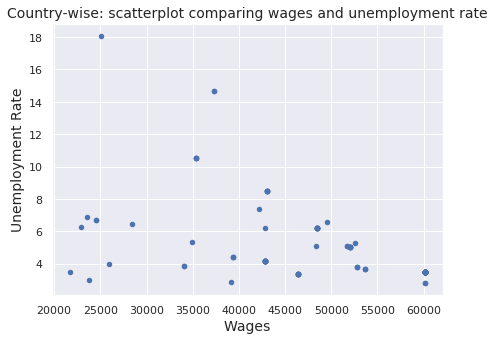

In [205]:
ax = df.plot(kind='scatter', x='Wages', y = 'Unemployment Rate', figsize=(7,5))
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
ax.set_ylabel(ax.get_ylabel(), fontsize=14)
plt.title("Country-wise: scatterplot comparing wages and unemployment rate", fontsize=14)
plt.show()

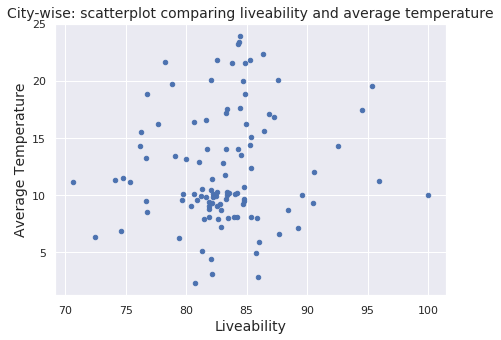

In [206]:
ax = df.plot(kind='scatter', x='Liveability', y = 'Average Temperature', figsize=(7,5))
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
ax.set_ylabel(ax.get_ylabel(), fontsize=14)
plt.title("City-wise: scatterplot comparing liveability and average temperature", fontsize=14)
plt.show()

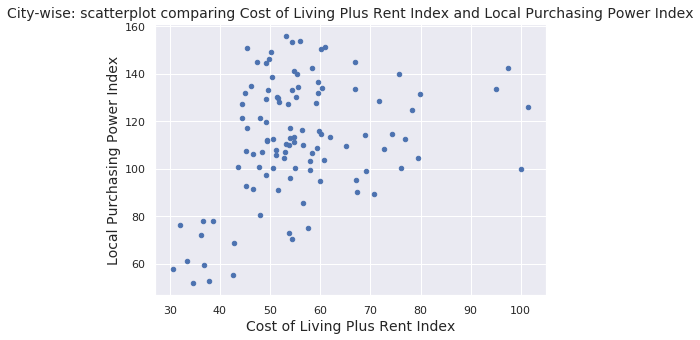

In [207]:
c = "Cost of Living Plus Rent Index"
l = "Local Purchasing Power Index"
ax = df.plot(kind='scatter', x=c, y = l, figsize=(7,5))
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
ax.set_ylabel(ax.get_ylabel(), fontsize=14)
plt.title("City-wise: scatterplot comparing %s and %s" % (c, l), fontsize=14)
plt.show()

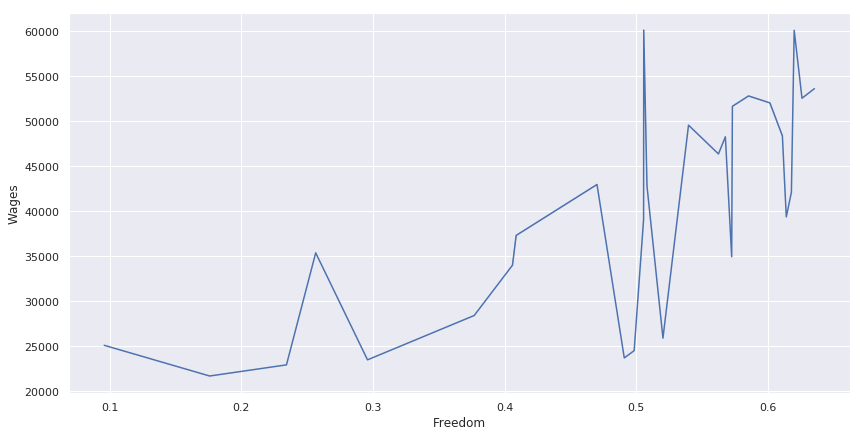

In [208]:
#c = "Cost of Living Plus Rent Index"
#l = "Local Purchasing Power Index"
c = "Freedom"
l = "Wages"
sns.set(rc={"figure.figsize":(14,7)})
ax = sns.lineplot(data=df, x=c, y=l)
ax.set(xlabel=c, ylabel=l)
plt.show()

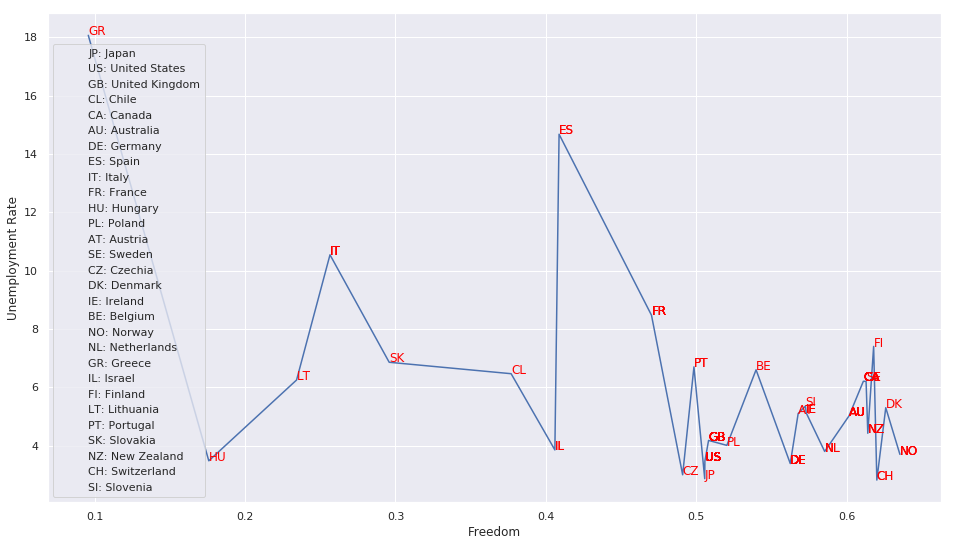

In [209]:
import matplotlib.patches as mpatches
#c = "Cost of Living Plus Rent Index"
#l = "Local Purchasing Power Index"
c = "Freedom"
l = "Unemployment Rate"
sns.set(rc={"figure.figsize":(16,9)})
ax = sns.lineplot(data=df[[l, c, "Country"]].drop_duplicates(), x=c, y=l)
ax.set(xlabel=c, ylabel=l)
for i, txt in enumerate(df['Country'].values):
    ax.annotate(txt, (df[c].iloc[i], df[l].iloc[i]), fontsize=12, color="red")

all_patches = [mpatches.Patch(color='None', label=countryCode + ": " + countryName) for countryCode, countryName in zip(df.Country.unique(), df.CountryName.unique())]
plt.legend(handles=all_patches)
plt.show()

Text(0,0.5,'Amount of cities in the respective country')

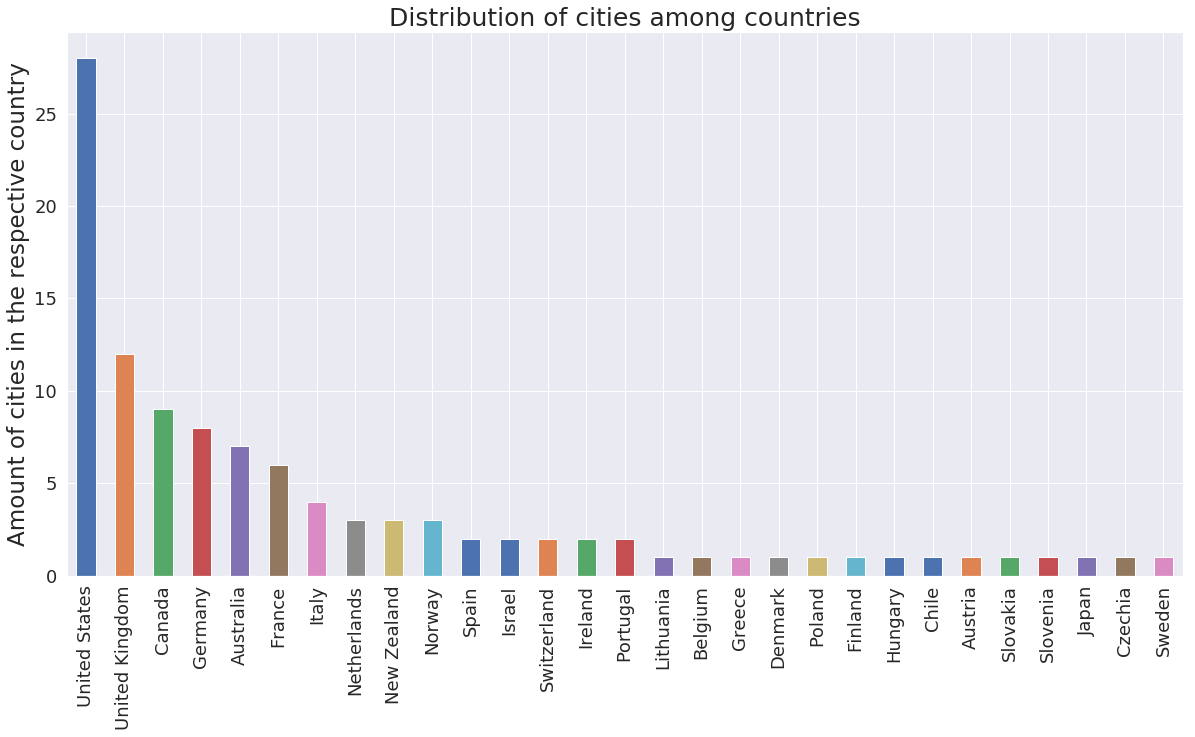

In [210]:
plt.rc('font', size=40)
df['CountryName'].value_counts().plot(kind='bar', figsize=(20,10), fontsize=18)
plt.title('Distribution of cities among countries', fontsize=25)
plt.ylabel('Amount of cities in the respective country', fontsize=23)

In [211]:
pd.set_option('display.float_format', '{:.2f}'.format) #set format of displayed values
df['Population'].describe()

count        107.00
mean     1417389.01
std      3232204.59
min       173535.00
25%       389205.00
50%       610892.00
75%      1255059.50
max     31480498.00
Name: Population, dtype: float64

Text(0.5,1,'Density of the population (excluding Tokyo)')

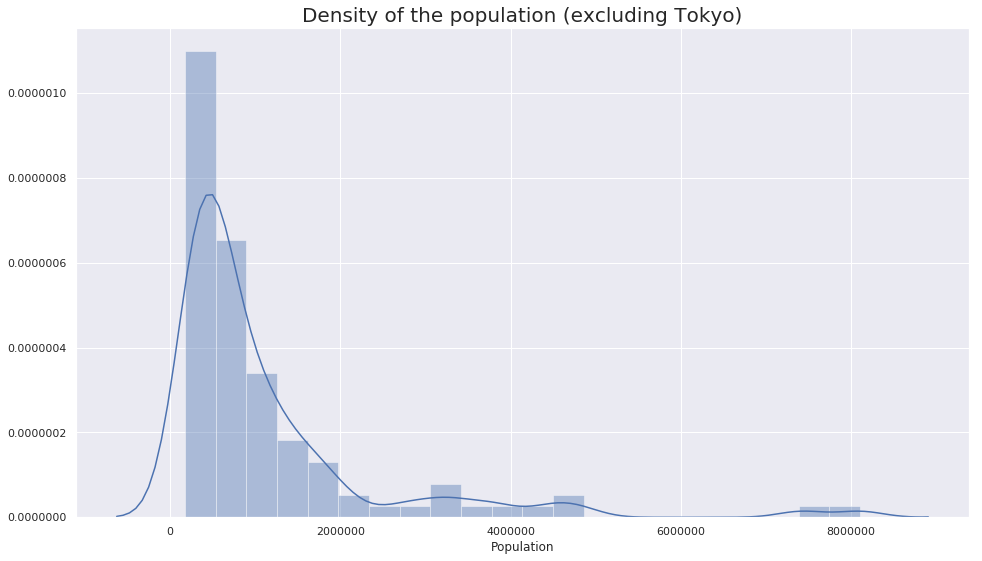

In [212]:
ax = plt.subplot()
ax.ticklabel_format(style='plain')
df_notok = df[df.City != "tokyo"]
sns.distplot(df_notok['Population'])
sns.set(rc={'figure.figsize':(10,7)})
plt.rcParams["axes.labelsize"] = 20
plt.title('Density of the population (excluding Tokyo)', fontsize=20)

In [213]:
df['Cost of Living Plus Rent Index'].describe()

count   107.00
mean     55.96
std      13.35
min      30.63
25%      48.76
50%      54.02
75%      60.06
max     101.43
Name: Cost of Living Plus Rent Index, dtype: float64

Text(0.5,1,'Density of Cost of Living Plus Rent Index')

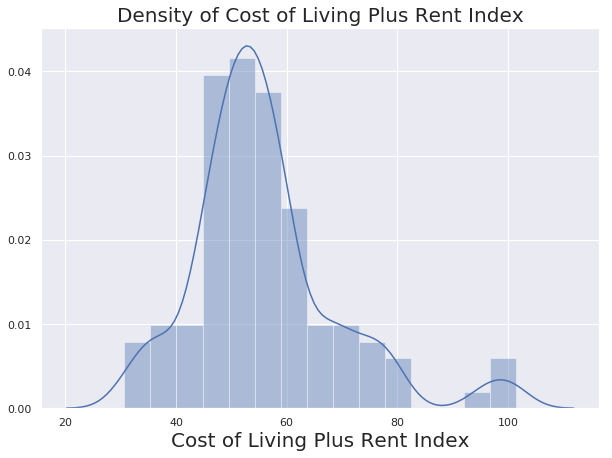

In [214]:
sns.distplot(df['Cost of Living Plus Rent Index'])
plt.title('Density of Cost of Living Plus Rent Index', fontsize=20)

In [215]:
df['Local Purchasing Power Index'].describe()

count   107.00
mean    112.04
std      24.95
min      51.83
25%      99.72
50%     112.36
75%     131.65
max     155.88
Name: Local Purchasing Power Index, dtype: float64

Text(0.5,1,'Density of Local Purchasing Power Index')

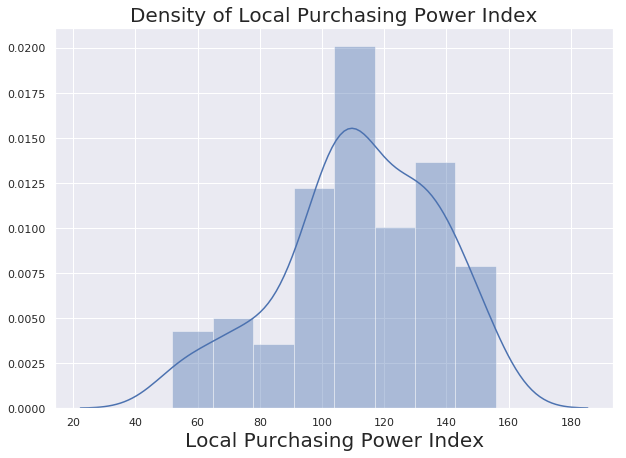

In [216]:
sns.distplot(df['Local Purchasing Power Index'])
plt.title('Density of Local Purchasing Power Index', fontsize=20)

In [217]:
df['Average Temperature'].describe()

count   107.00
mean     12.17
std       5.00
min       2.30
25%       9.06
50%      10.30
75%      15.58
max      23.92
Name: Average Temperature, dtype: float64

Text(0.5,1,'Density of Average Temperature')

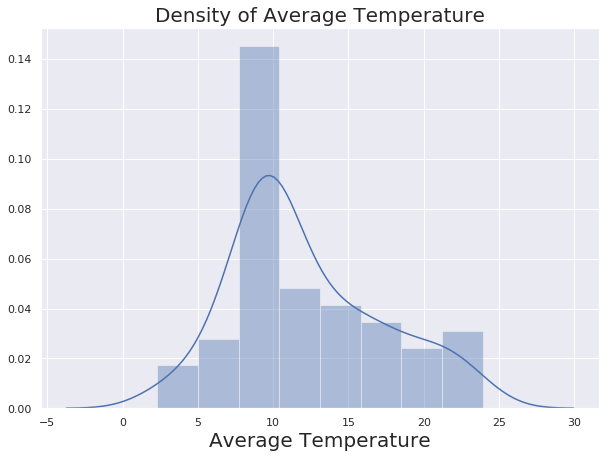

In [218]:
sns.distplot(df['Average Temperature'])
plt.title('Density of Average Temperature', fontsize=20)

In [219]:
df['Liveability'].describe()

count   107.00
mean     83.10
std       4.60
min      70.63
25%      81.28
50%      83.01
75%      84.87
max     100.00
Name: Liveability, dtype: float64

Text(0.5,1,'Density of Liveability')

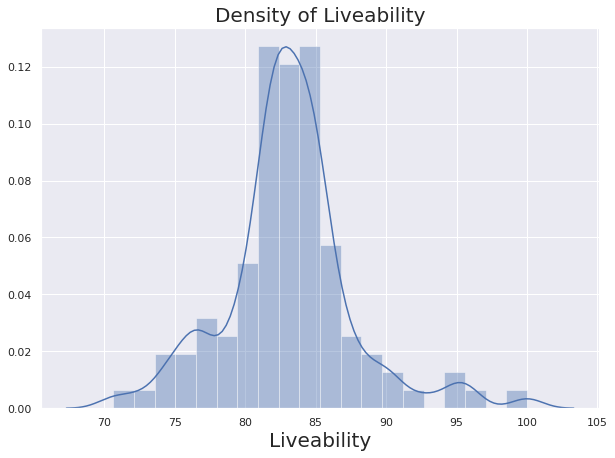

In [220]:
sns.distplot(df['Liveability'])
plt.title('Density of Liveability', fontsize=20)

In [221]:
df['Unemployment Rate'].describe()

count   107.00
mean      5.12
std       2.60
min       2.82
25%       3.47
50%       4.18
75%       6.21
max      18.07
Name: Unemployment Rate, dtype: float64

Text(0.5,1,'Density of Unemployment Rate')

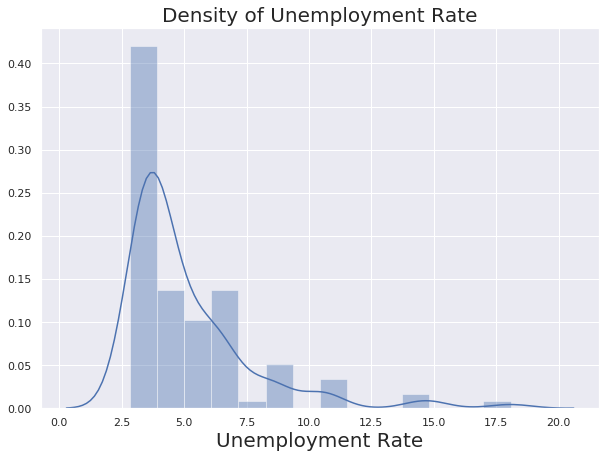

In [222]:
sns.distplot(df['Unemployment Rate'])
plt.title('Density of Unemployment Rate', fontsize=20)

In [223]:
df['Freedom'].describe()

count   107.00
mean      0.51
std       0.10
min       0.10
25%       0.51
50%       0.51
75%       0.59
max       0.64
Name: Freedom, dtype: float64

Text(0.5,1,'Density of Freedom')

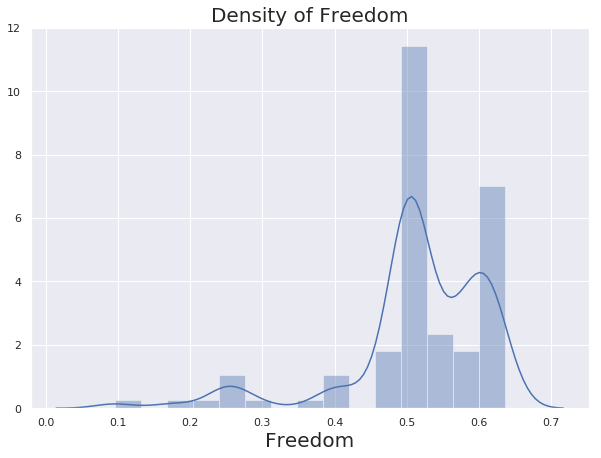

In [224]:
sns.distplot(df['Freedom'])
plt.title('Density of Freedom', fontsize=20)

Text(0.5,1,'Density of Wages in USD')

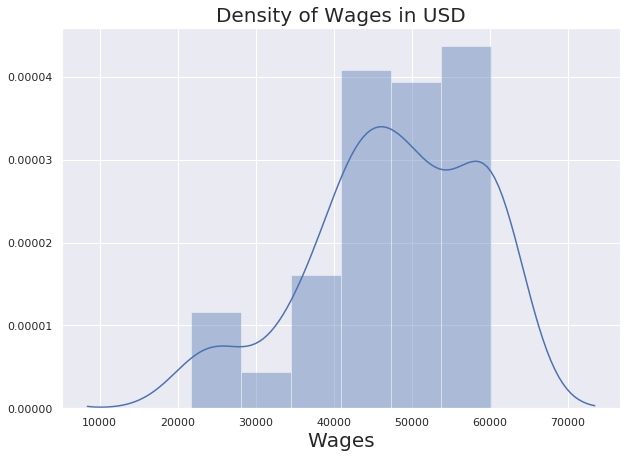

In [225]:
sns.distplot(df['Wages'])
plt.title('Density of Wages in USD', fontsize=20)

Text(0.5,0,'City')

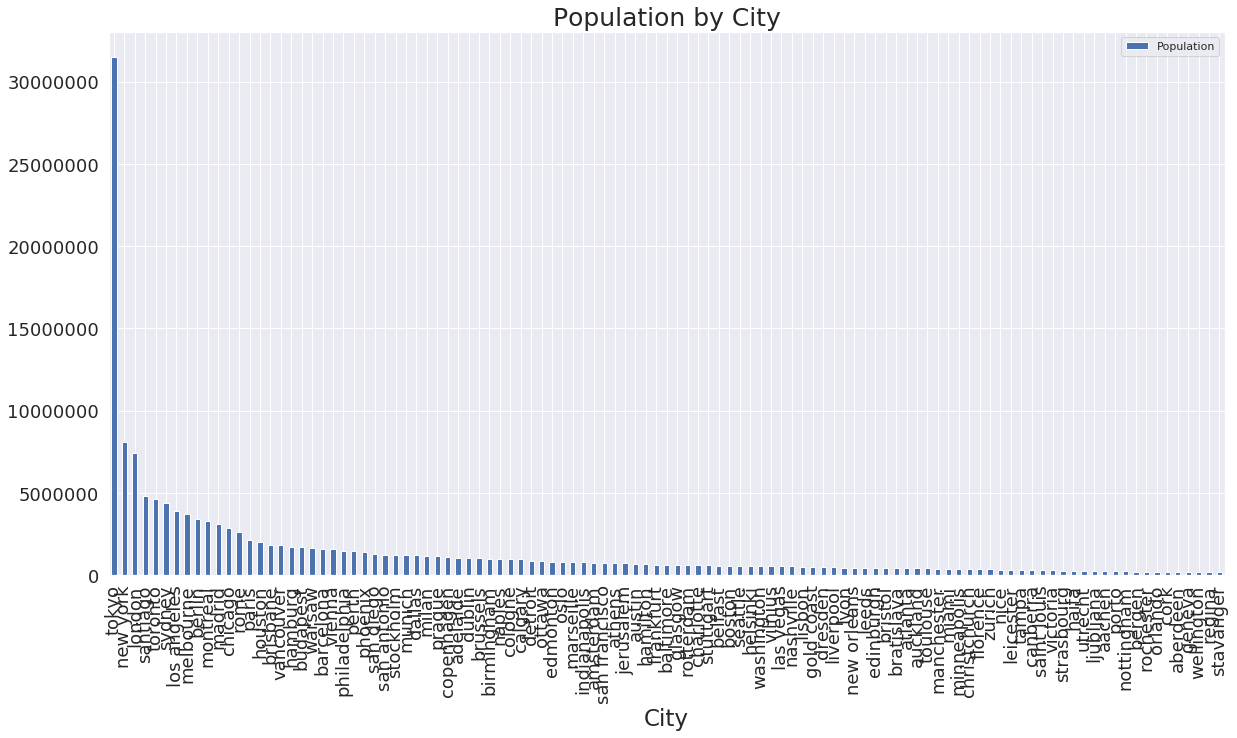

In [226]:
df[['City','Population']].groupby('City').mean().sort_values('Population', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Population by City', fontsize=25)
plt.xlabel('City', fontsize=23)

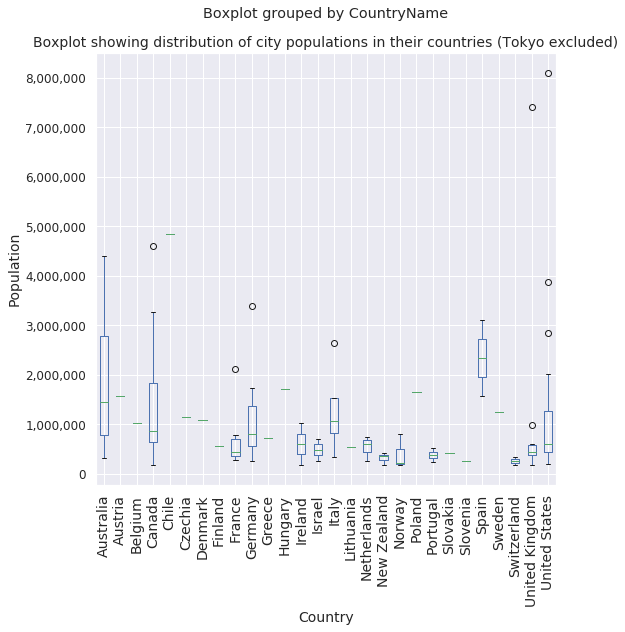

In [227]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
df_no_tokyo = df[df["City"] != "tokyo"]
#df_no_tokyo = df
ax = df_no_tokyo[['City', 'CountryName', 'Population']].boxplot(column="Population", by="CountryName", ax=ax)
ax.set_xlabel("Country", fontsize=14)
ax.set_ylabel("Population", fontsize=14)
plt.title("Boxplot showing distribution of city populations in their countries (Tokyo excluded)", fontsize=14)
plt.xticks(rotation=90, fontsize=14)

vals = ax.get_yticks()
ax.set_yticklabels(["{:,}".format(int(x)) for x in vals])
plt.yticks(fontsize=12)
plt.show()

Text(0.5,0,'Cost of Living Plus Rent Index')

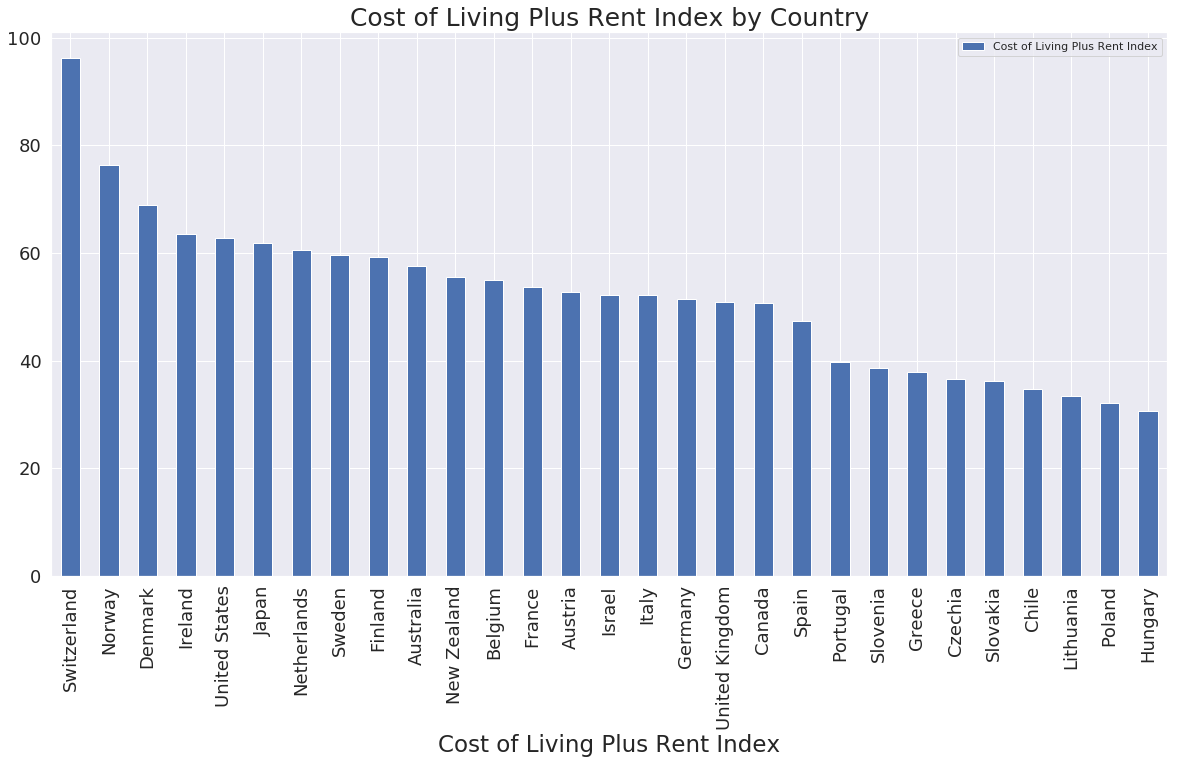

In [228]:
df[['CountryName', 'Cost of Living Plus Rent Index']].groupby('CountryName').mean().sort_values('Cost of Living Plus Rent Index', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Cost of Living Plus Rent Index by Country', fontsize=25)
plt.xlabel('Cost of Living Plus Rent Index', fontsize=23)

Text(0.5,0,'Local Purchasing Power Index')

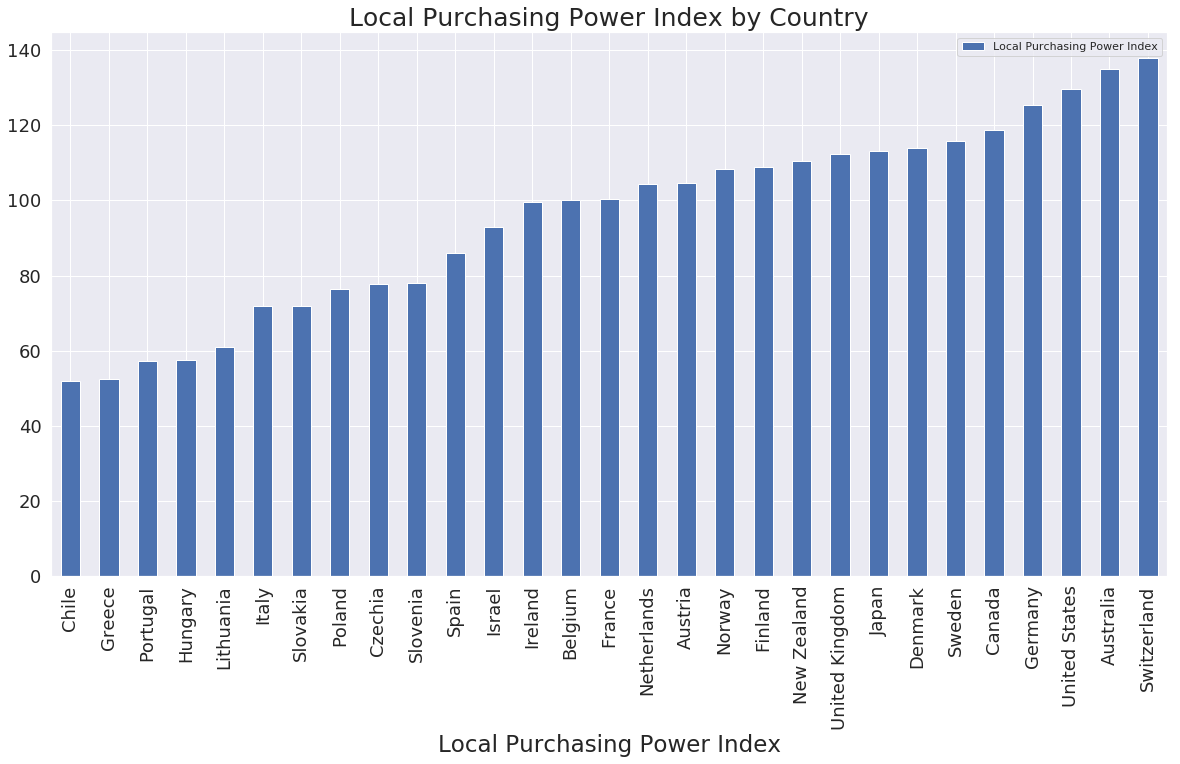

In [229]:
df[['CountryName', 'Local Purchasing Power Index']].groupby('CountryName').mean().sort_values('Local Purchasing Power Index', ascending=True).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Local Purchasing Power Index by Country', fontsize=25)
plt.xlabel('Local Purchasing Power Index', fontsize=23)

Text(0.5,0,'Average Temperature')

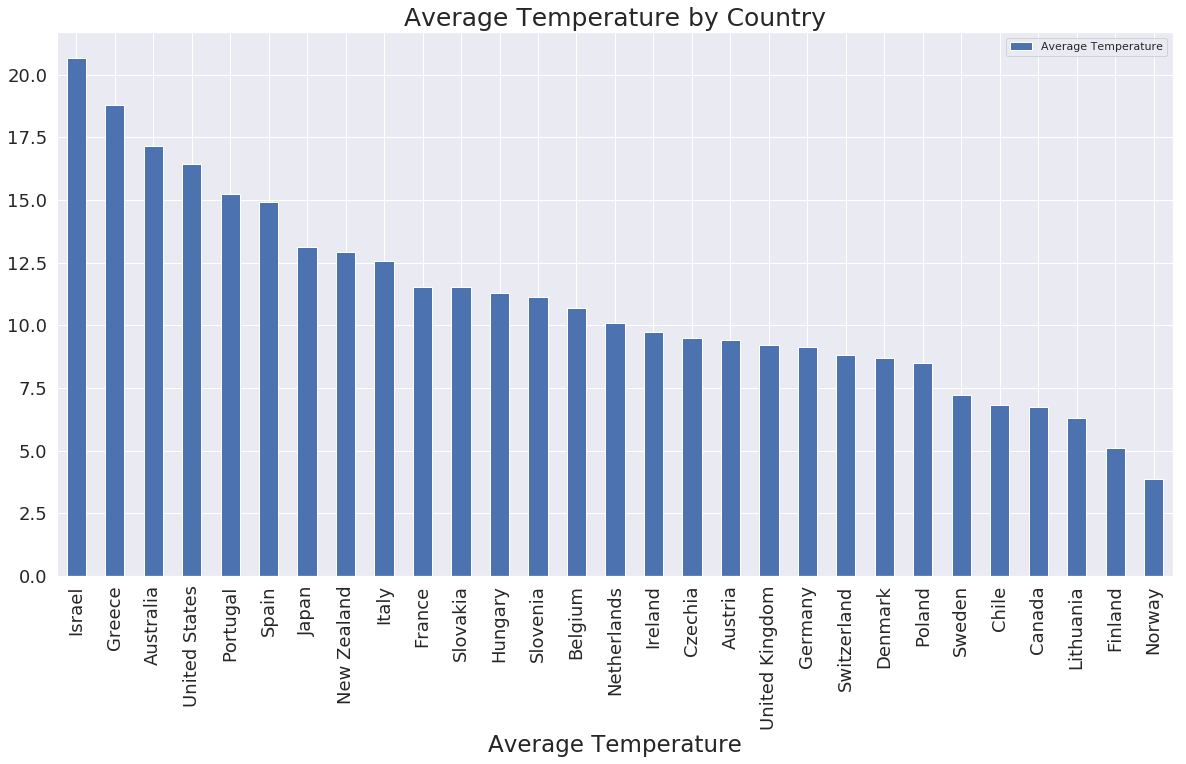

In [230]:
df[['CountryName', 'Average Temperature']].groupby('CountryName').mean().sort_values('Average Temperature', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Average Temperature by Country', fontsize=25)
plt.xlabel('Average Temperature', fontsize=23)

Text(0.5,0,'Unemployment Rate')

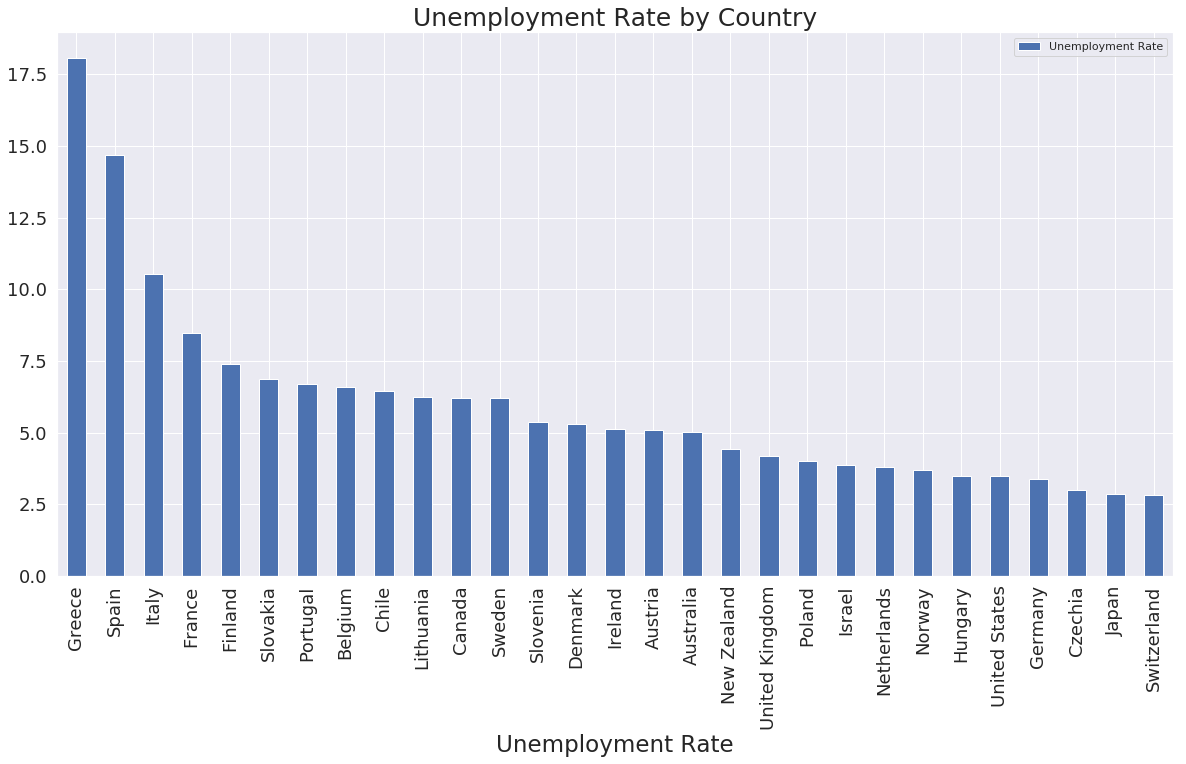

In [231]:
df[['CountryName', 'Unemployment Rate']].groupby('CountryName').mean().sort_values('Unemployment Rate', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Unemployment Rate by Country', fontsize=25)
plt.xlabel('Unemployment Rate', fontsize=23)

Text(0.5,0,'Freedom')

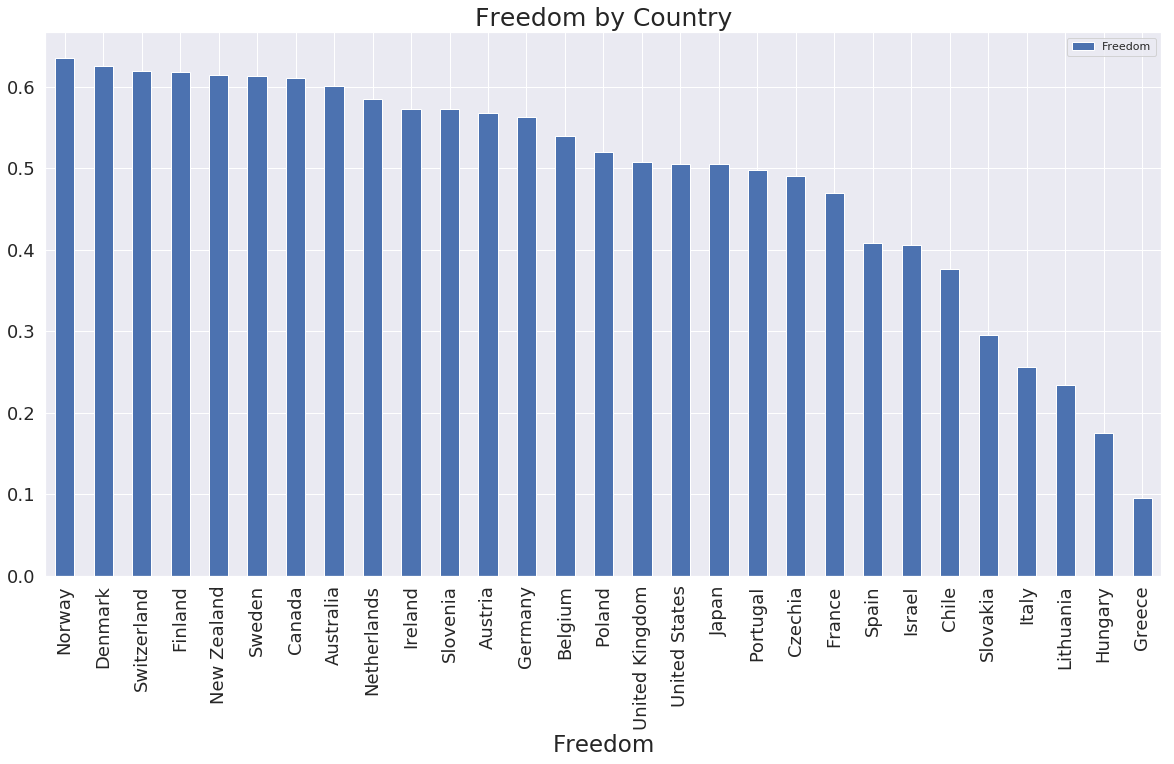

In [232]:
df[['CountryName', 'Freedom']].groupby('CountryName').mean().sort_values('Freedom', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Freedom by Country', fontsize=25)
plt.xlabel('Freedom', fontsize=23)

Text(0.5,0,'Wages')

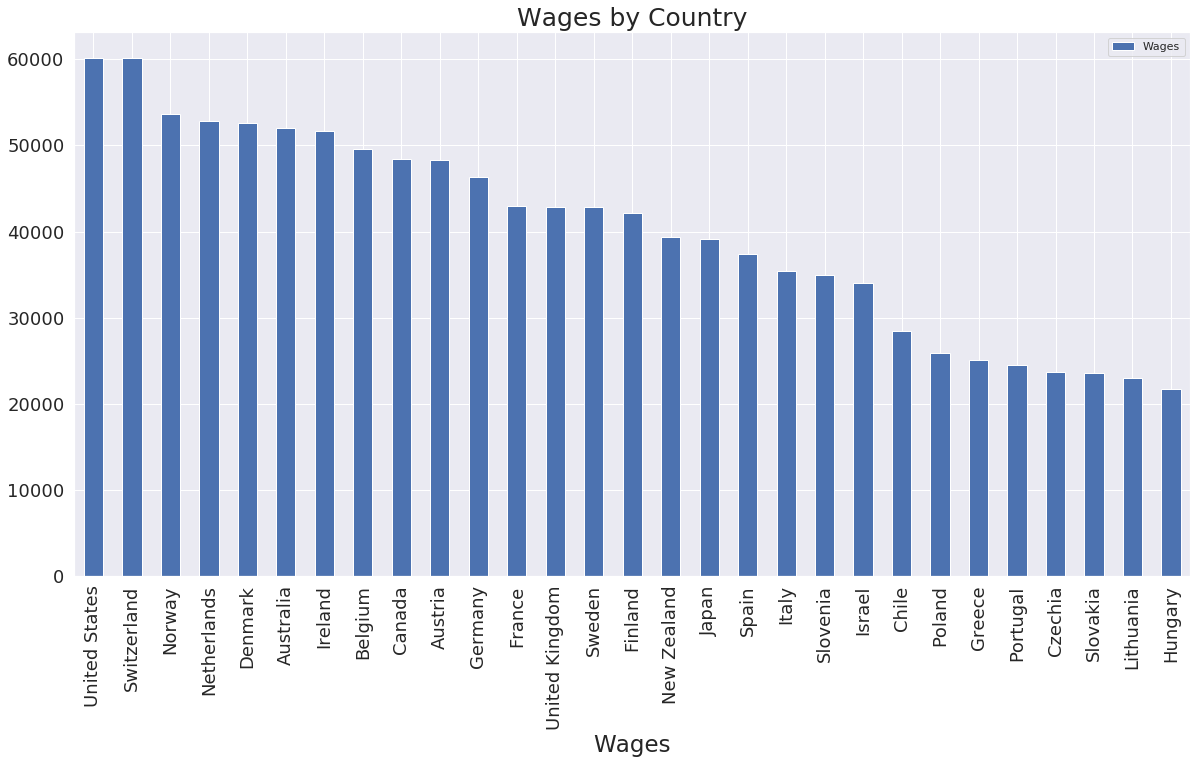

In [233]:
df[['CountryName', 'Wages']].groupby('CountryName').mean().sort_values('Wages', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Wages by Country', fontsize=25)
plt.xlabel('Wages', fontsize=23)

Text(0.5,0,'Liveability')

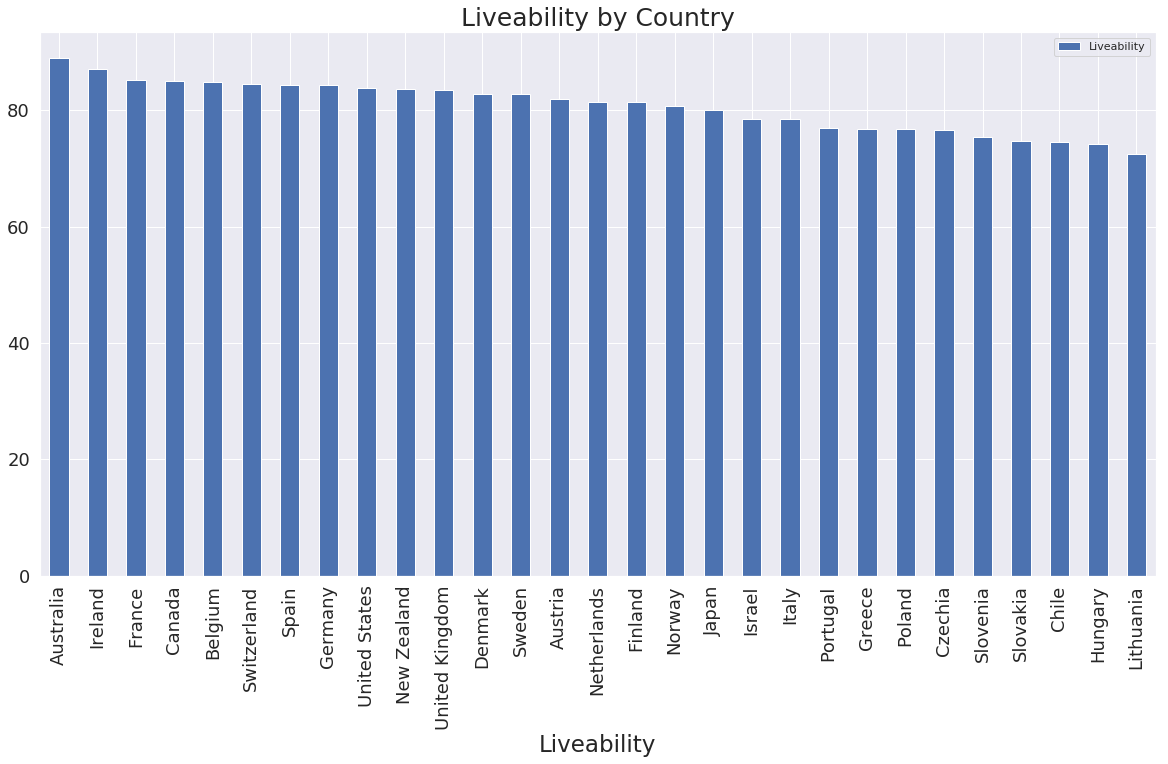

In [234]:
df[['CountryName', 'Liveability']].groupby('CountryName').mean().sort_values('Liveability', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Liveability by Country', fontsize=25)
plt.xlabel('Liveability', fontsize=23)

<h2>Distance function and distance matrix</h2>

In [235]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Average Temperature,Liveability,Unemployment Rate,Freedom,Wages,CountryName
0,tokyo,JP,31480498.00,35.69,139.75,61.89,113.09,13.11,80.00,2.87,0.51,39113,Japan
1,new york,US,8107916.00,40.71,-74.01,100.00,100.00,11.97,90.53,3.47,0.51,60154,United States
2,los angeles,US,3877129.00,34.05,-118.24,74.25,114.51,17.09,86.86,3.47,0.51,60154,United States
3,chicago,US,2841952.00,41.85,-87.65,67.01,133.70,12.82,83.01,3.47,0.51,60154,United States
4,houston,US,2027712.00,29.76,-95.36,53.14,155.88,21.86,85.24,3.47,0.51,60154,United States


In [236]:
# Normalize columns to [0 ; 1] interval.
cities_indices = df["City"]
normalised_data = df.copy()
normalised_data.drop(["City", "Country", "CountryName"], axis=1, inplace=True)
def scaled_value(value, column):
    return ((value - normalised_data[column].min()) /
            (normalised_data[column].max() - normalised_data[column].min()))
for col in normalised_data:
    if col not in ["City", "Country", "CountryName"]:
        normalised_data[col] = normalised_data.apply(lambda row: scaled_value(row[col], col), axis = 1)

In [237]:
df.describe()

,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Average Temperature,Liveability,Unemployment Rate,Freedom,Wages
count,107.00,107.00,107.00,107.00,107.00,107.00,107.00,107.00,107.00,107.00
mean,1417389.01,37.04,-13.44,55.96,112.04,12.17,83.10,5.12,0.51,47690.68
std,3232204.59,25.80,74.29,13.35,24.95,5.00,4.60,2.60,0.10,10654.89
min,173535.00,-43.53,-123.35,30.63,51.83,2.30,70.63,2.82,0.10,21711.00
25%,389205.00,35.93,-80.01,48.76,99.72,9.06,81.28,3.47,0.51,42835.00
50%,610892.00,44.98,-1.13,54.02,112.36,10.30,83.01,4.18,0.51,48403.00
75%,1255059.50,51.48,12.53,60.06,131.65,15.58,84.87,6.21,0.59,60154.00
max,31480498.00,60.39,174.78,101.43,155.88,23.92,100.00,18.07,0.64,60154.00


In [238]:
normalised_data.describe()

,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Average Temperature,Liveability,Unemployment Rate,Freedom,Wages
count,107.00,107.00,107.00,107.00,107.00,107.00,107.00,107.00,107.00,107.00
mean,0.04,0.78,0.37,0.36,0.58,0.46,0.42,0.15,0.78,0.68
std,0.10,0.25,0.25,0.19,0.24,0.23,0.16,0.17,0.19,0.28
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.01,0.76,0.15,0.26,0.46,0.31,0.36,0.04,0.76,0.55
50%,0.01,0.85,0.41,0.33,0.58,0.37,0.42,0.09,0.76,0.69
75%,0.03,0.91,0.46,0.42,0.77,0.61,0.48,0.22,0.92,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [239]:
# The distance function.
def distanceFce(indA, indB):
    rowA = normalised_data.iloc[indA]
    rowB = normalised_data.iloc[indB]
    # Absolute difference.
    result = np.abs(rowA.values - rowB.values)
    
    # Emphasize freedom importance in non-free countries.
    freedom_diff = np.abs(rowA["Freedom"] - rowB["Freedom"])
    if rowA["Freedom"] < 0.76 or rowB["Freedom"] < 0.76:
        result[-2] = np.sqrt(freedom_diff)
    
    # Emphasize big difference in cost of living index.
    coli_diff = np.abs(rowA["Cost of Living Plus Rent Index"] - rowB["Cost of Living Plus Rent Index"])
    if coli_diff > 0.2:
        result[3] = np.sqrt(coli_diff)
    
    # Linear weighting.
    return np.dot(np.array([
        0.05, # Population
        0.0, # Latitude
        0.0, # Longitude
        0.2, # Cost of living + rent index
        0.1, # Local purchasing power index
        0.05, # Average temperature
        0.2, # Liveability
        0.1, # Unemployment rate
        0.2, # Freedom
        0.1, # Wages
    ]), result)

In [335]:
# Compute the distance matrix using our distance function.
indices = normalised_data.index.values
v = np.vectorize(distanceFce)
matrix = v(indices[:, np.newaxis], indices)

In [336]:
matrix.shape

(107, 107)

<h2>Clustering</h2>

In [242]:
# Function plotting the cities and their clusters (represented by color) on a map.
def plot_cities(lons, lats, labels, europe=False, figsize=(10,10), cities=None):
    plt.figure(figsize=figsize)
    if europe:
        ax = plt.axes(projection=ccrs.EuroPP())
    else:
        ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    colors = ["red", "green", "blue", "yellow", "purple", "black", "orange", "brown"]
    cs = [colors[l] for l in labels]
    ret = plt.scatter(lons, lats,
                color=cs, marker='o',
                transform=ccrs.Geodetic()
               )
    plt.show()

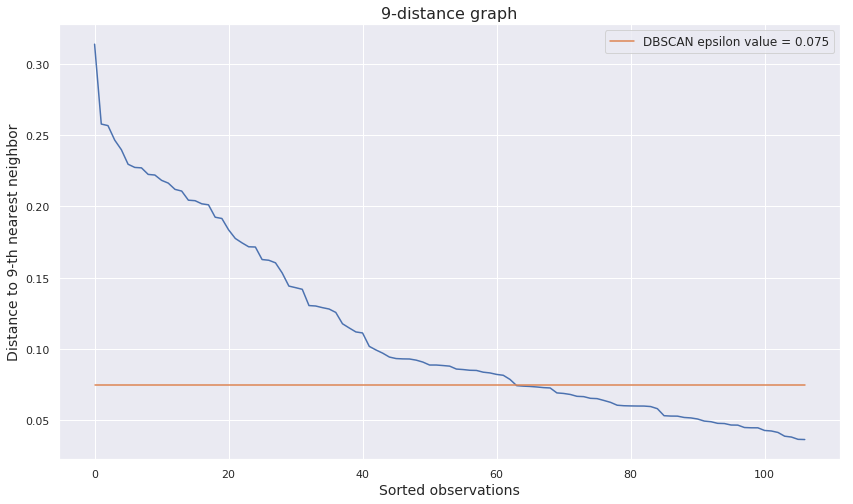

In [337]:
# Decide eps for DBSCAN using k-distance graph.
# We chose k=min_samples.
min_samples = 9
nbrs = NearestNeighbors(metric="precomputed").fit(matrix)
distances, indices = nbrs.kneighbors(n_neighbors=min_samples)
kdist = distances[:, -1]
kdist.sort()
kdist = kdist[::-1]
plt.figure(figsize=(14,8))
plt.plot(range(len(kdist)), kdist)
eps = 0.075
ln = plt.plot(range(len(kdist)), len(kdist)*[eps])
plt.ylabel("Distance to %d-th nearest neighbor" % min_samples, fontsize=14)
plt.xlabel("Sorted observations", fontsize=14)
plt.legend(ln, ["DBSCAN epsilon value = %.3f" % eps], fontsize=12)
plt.title("%d-distance graph" % min_samples, fontsize=16)
plt.show()

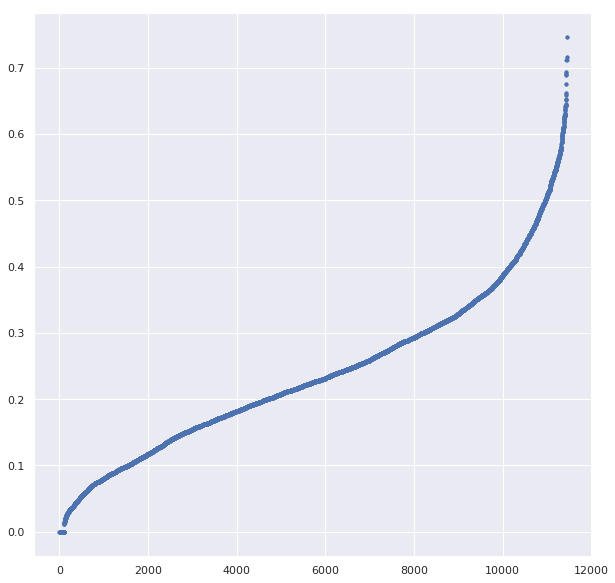

In [338]:
# TODO probaby delete.
#pd.DataFrame(matrix.reshape(-1)).plot(kind="box", figsize=(8,8))
plt.figure(figsize=(10,10))
plt.plot(np.sort(matrix.reshape(-1)), ".")

<h2>DBSCAN</h2>

In [345]:
# Train DBSCAN model.
model = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed")
labels_1 = model.fit(matrix).labels_
# Get number of clusters and number of cities in each of them.
np.unique(labels_1, return_counts=True)

(array([-1,  0,  1]), array([42, 25, 40]))

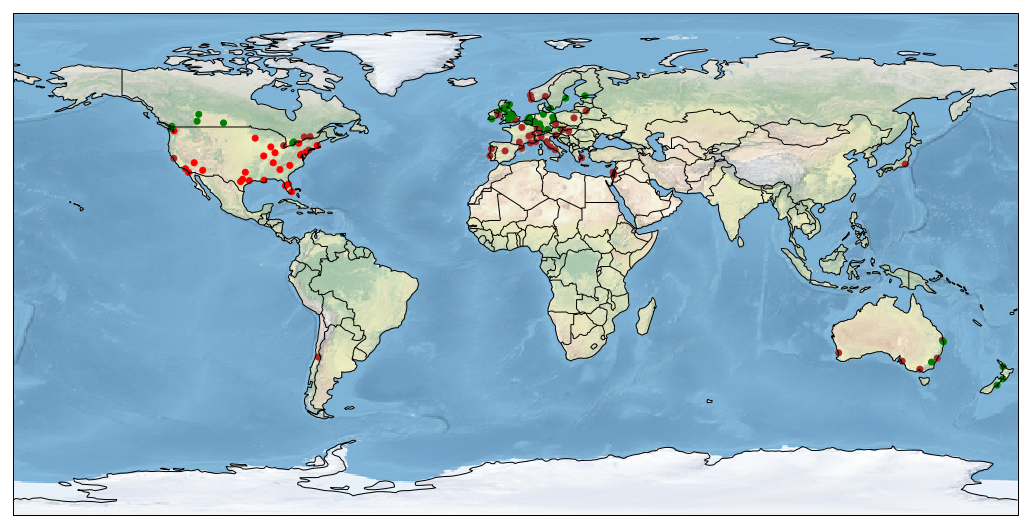

In [346]:
# Plot world map.
plot_df = df.copy()
plot_df["labels"] = labels_1
plot_cities(plot_df['Longitude'], plot_df['Latitude'], labels=labels_1, europe=False, figsize=(18, 12), cities=plot_df.City.values)

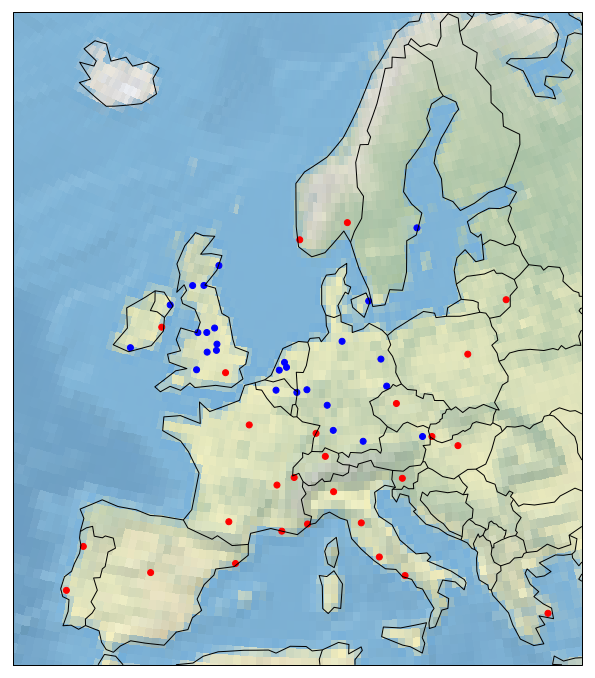

In [97]:
# Plot map of Europe.
plot_df = df.copy()
plot_df["labels"] = labels_1
plot_df = plot_df[(plot_df["Longitude"] > -10) & (plot_df["Longitude"] < 30) & (plot_df["Latitude"] > 35 ) & (plot_df["Latitude"] < 60)]
plot_cities(plot_df['Longitude'], plot_df['Latitude'], labels=plot_df["labels"].values, europe=True, figsize=(18, 12), cities=plot_df.City.values)

<h2>Spectral clustering</h2>

In [341]:
# Train spectral clustering model.
k = 5
model = SpectralClustering(n_clusters=k, affinity="precomputed")
labels_1 = model.fit(1-matrix).labels_

In [342]:
# Get number of clusters and number of cities in each of them.
np.unique(labels_1, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([14, 44, 15, 10, 24]))

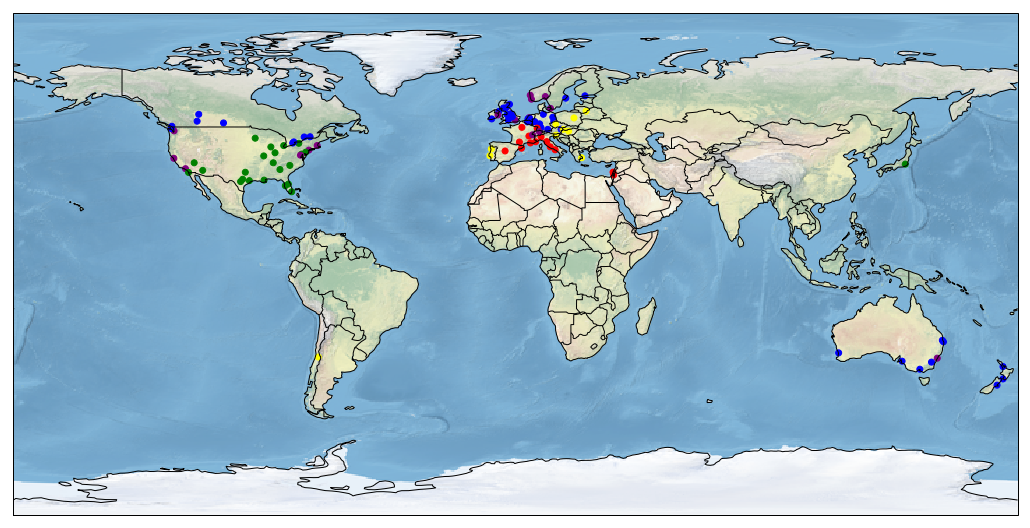

In [323]:
# Plot world map.
plot_df = df.copy()
plot_df["labels"] = labels_1
plot_cities(plot_df['Longitude'], plot_df['Latitude'], labels=labels_1, europe=False, figsize=(18, 12), cities=plot_df.City.values)

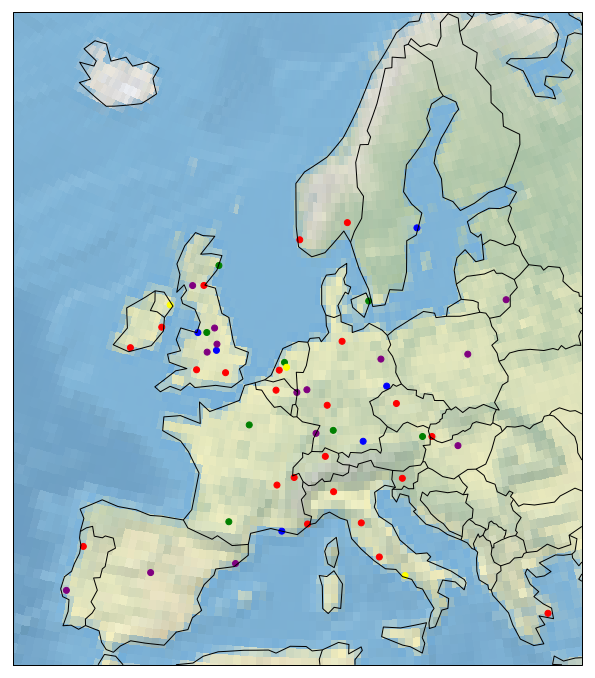

In [102]:
# Plot map of Europe.
plot_df = df.copy()
plot_df["labels"] = labels_1
plot_df = plot_df[(plot_df["Longitude"] > -10) & (plot_df["Longitude"] < 30) & (plot_df["Latitude"] > 35 ) & (plot_df["Latitude"] < 60)]
plot_cities(plot_df['Longitude'], plot_df['Latitude'], labels=plot_df["labels"].values, europe=True, figsize=(18, 12), cities=plot_df.City.values)

<h2>HELL</h2>

In [347]:
sydney_index = df[df.City == "sydney"].index[0]
melbourne_index = df[df.City == "melbourne"].index[0]
berlin_index = df[df.City == "berlin"].index[0]
prague_index = df[df.City == "prague"].index[0]
munich_index = df[df.City == "munich"].index[0]
amsterdam_index = df[df.City == "amsterdam"].index[0]
ljubljana_index = df[df.City == "ljubljana"].index[0]
zurich_index = df[df.City == "zurich"].index[0]
copenhagen_index = df[df.City == "copenhagen"].index[0]

In [348]:
best_df = plot_df[plot_df.City.isin(["munich", "prague", "melbourne", "sydney", "berlin", "amsterdam", "copenhagen", "hamburg", "zurich", "ljubljana"])]
best_df[["City", "CountryName", "labels"]]

,City,CountryName,labels
51,sydney,Australia,-1
52,melbourne,Australia,-1
58,berlin,Germany,1
59,hamburg,Germany,1
60,munich,Germany,1
82,prague,Czechia,-1
83,copenhagen,Denmark,1
90,amsterdam,Netherlands,1
104,zurich,Switzerland,-1
106,ljubljana,Slovenia,-1


In [350]:
matrix[copenhagen_index, amsterdam_index]

0.052227999419179813

In [351]:
matrix[zurich_index, ljubljana_index]

0.42285479123852304